In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

In [28]:
from scipy.optimize import curve_fit
#import sympy as sp

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import gstools as gs

In [29]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

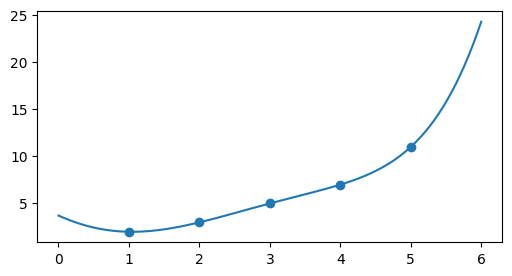

In [30]:
def poly_fit(x, y, n):
    # Создание матрицы A
    A = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(n+1):
            A[i, j] = np.sum(x**(i+j))

    # Создание вектора b
    b = np.zeros(n+1)
    for i in range(n+1):
        b[i] = np.sum(y * x**(i))

    # Решение системы линейных уравнений
    a = np.linalg.solve(A, b)
    return a


def f(x, coeffs):
    n = len(coeffs)
    y = coeffs[0]
    for i in range(1, n):
        y += coeffs[i] * x ** i
    return y


# Пример использования
xi = np.array([1, 2, 3, 4, 5])
yi = np.array([2, 3, 5, 7, 11])
n = 5

coeffs = poly_fit(xi, yi, n)

x_plot = np.linspace(0, 6, 100)

plt.figure(figsize=(6, 3))
plt.plot(x_plot, f(x_plot, coeffs), label='Полином')
plt.scatter(xi, yi, label='Точки')
plt.show()

In [31]:
"""
Случайная разбивка данных
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")
df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

data_train, data_test = train_test_split(
    df_now.loc[:, ["x", "h", "E"]].to_numpy(), test_size=0.3, random_state=123)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]


r2_dict = {}

In [32]:
"""
Случайная разбивка данных  + добавление постоянных значений в тестовую выборку
    -только суглинок (залегает от 73,5 до 67-64,4)
    -пласт подряд идущих данных отнесен к тестовой выборке
    -отсортированные данные
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")

df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

data_train, data_test = train_test_split(
    df_now.iloc[:91].to_numpy(),
    #pd.concat([df_now.iloc[:91], df_now.iloc[128:]]).to_numpy(), 
    test_size=0.1, 
    random_state=123
)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = np.concatenate([data_test,
                            df_now.iloc[92:].to_numpy()
                            #df_now.iloc[92:128].to_numpy()
                           ]
                          )
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]

r2_dict = {}

In [33]:
"""
Случайная разбивка данных  + добавление постоянных значений в тестовую выборку
    -только суглинок (залегает от 73,5 до 67-64,4)
    -пласт подряд идущих данных отнесен к тестовой выборке
    -отсортированные данные
"""
borehole = 147
z_borehole = 76.385 # абсолютная отметка устья скважины
clay_border = [73.5, 65]
#df_now = group_E.query('group == 65')
df = pd.read_excel(f"data/тсз{borehole}.xlsx")

df["z_sample"] = z_borehole - df["h"]
df = df.query('z_sample < @clay_border[0] & z_sample > @clay_border[1]') 
df["x"] = 0
df = df.loc[:, ["x", "h", "E"]]
df_now = get_filter_df(df, "E")

data_train, data_test = train_test_split(
    #df_now.iloc[:91].to_numpy(),
    pd.concat([df_now.iloc[:91], df_now.iloc[128:]]).to_numpy(), 
    test_size=0.1, 
    random_state=123
)

data_train = data_train[np.argsort(data_train[:, 1])]
data_test = np.concatenate([data_test,
                            #df_now.iloc[92:].to_numpy()
                            df_now.iloc[92:128].to_numpy()
                           ]
                          )
data_test = data_test[np.argsort(data_test[:, 1])]
p_train, x_train, target_train = data_train[:, :2], data_train[:, :2], data_train[:, 2]
p_test, x_test, target_test = data_test[:, :2], data_test[:, :2], data_test[:, 2]

r2_dict = {}

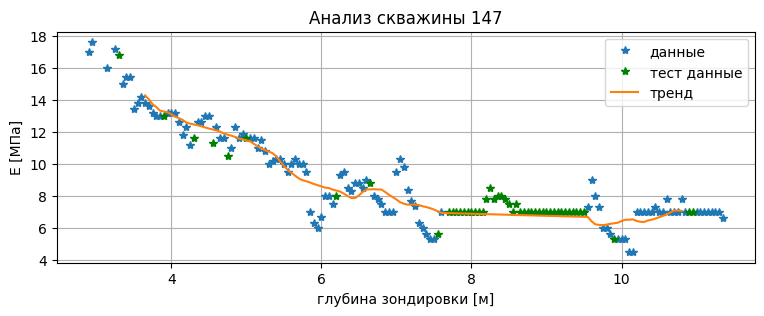

In [34]:
window_size = 20  # Размер окна для скользящего среднего
df_temp = pd.DataFrame(data_train[:, 1:], columns = ["h", "E"])
df_temp['Trend'] = df_temp['E'].rolling(window=window_size, center=True).mean()
# Вычисление случайной составляющей как разность исходных данных и тренда
df_temp['Random'] = df_temp['E'] - df_temp['Trend']

plt.figure(figsize=(9, 3))
plt.plot(df_temp["h"], df_temp["E"], '*', label="данные")
plt.plot(x_test[:, 1], target_test, '*g', label="тест данные")
plt.plot(df_temp["h"], df_temp["Trend"], '-', label="тренд")
plt.title(f'Анализ скважины {borehole}')
plt.xlabel('глубина зондировки [м]')
plt.ylabel('E [МПа]')
plt.grid()
plt.legend()
plt.show()

# Сравнение разных моделей аппроксимации и интерполяции данных

-4.474069503267607 4.322448979591837 4.597204119275727


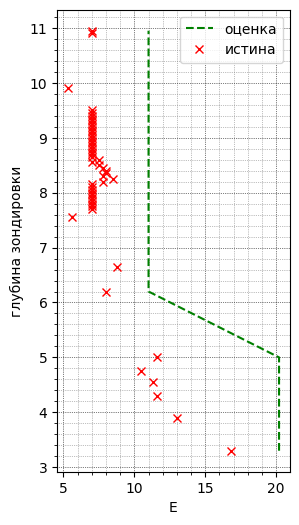

In [35]:
"""
Данные из Изысканий
ИГЭ 3а - 20,2
    с 2 до 5 м
ИГЭ 3б - 15,5
    с 5 до 6 м
ИГЭ 3в - 11
    с 6 до 11 м
"""
def result_from_ige(x):
    if x <= 2: # НС
        return 11.8
    if x <= 5: # 3а
        return 20.2
    if x <= 6: # 3б
        return 15.5
    if x <= 11: # 3в
        return 11
    return 7.8 # 5а


predict_test = [result_from_ige(i) for i in x_test[:, 1]]

r2_now = r2_score(target_test, predict_test)
mae_now = mean_absolute_error(target_test, predict_test)
mape_now = mean_absolute_percentage_error(target_test, predict_test)
rmse_now = mean_squared_error(target_test, predict_test)**0.5
print(r2_now, mae_now, rmse_now)
r2_dict["ИГИ"] = [r2_now, mae_now, rmse_now, mape_now]

plt.figure(figsize=(3, 6))
plt.plot(predict_test, x_test[:, 1], 'g--', label="оценка")
plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

### Полиномы

-42.86326865772026 10.54157479026105 13.01335056850181


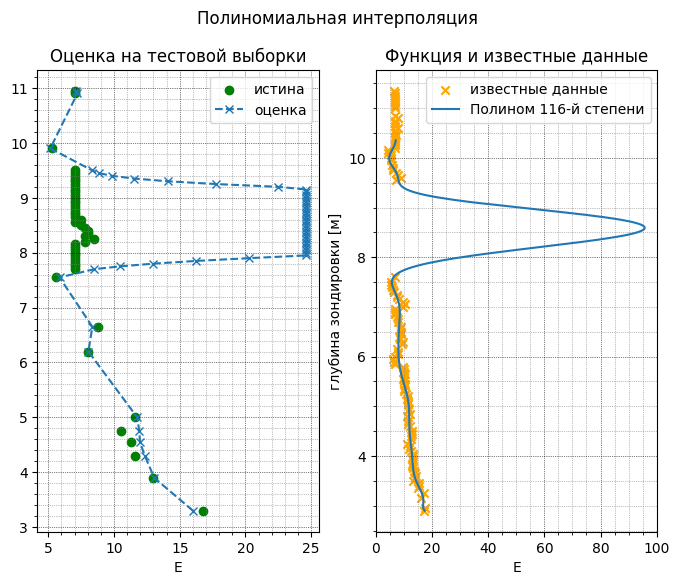

In [36]:
"""
Полином
"""
n = target_train.shape[0]

xi = x_train[:, 1]
yi = target_train

coeffs = np.polyfit(xi, yi, n)
poly = np.poly1d(coeffs)

x_new = np.linspace(min(xi), 
                    max(xi)-1, 
                    300
                   )
y_new = poly(xi)

predict_test = poly(x_test[:, 1])
predict_test = np.where(predict_test> np.max(xi)+np.var(xi)*2, np.max(xi)+np.var(xi)*2, predict_test)
predict_test = np.where(predict_test< np.min(xi)-np.var(xi)*2, 0, predict_test)

r2_now = r2_score(target_test, predict_test)
mae_now = mean_absolute_error(target_test, predict_test)
mape_now = mean_absolute_percentage_error(target_test, predict_test)
rmse_now = mean_squared_error(target_test, predict_test)**0.5
print(r2_now, mae_now, rmse_now)
r2_dict["Poly"] = [r2_now, mae_now, rmse_now, mape_now]



#подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

#график на первом поле
ax1.scatter(target_test, x_test[:, 1], color='green', label='истина')
ax1.plot(predict_test, x_test[:, 1],  "--x", label='оценка')
ax1.set_title('Оценка на тестовой выборки')
ax1.set_xlabel('E')
ax1.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax1.minorticks_on()
ax1.legend()

#график на втором поле
ax2.scatter(target_train, x_train[:, 1], marker="x", color='orange', label='известные данные')
ax2.plot(poly(x_new), x_new, label=f'Полином {n}-й степени')
ax2.set_title('Функция и известные данные')
ax2.set_xlabel('E')
ax2.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax2.minorticks_on()
ax2.legend()

# Установите общий заголовок
fig.suptitle('Полиномиальная интерполяция')
plt.ylabel('глубина зондировки [м]')
plt.show()

In [37]:
def cross_valid_for_poly(poly, blocks_X, blocks_y, k):
    scores = [] # Инициализация списка для хранения оценок
    
    for i in range(k):
        # Создание обучающей и тестовой выборок
        X_train = np.concatenate([blocks_X[j] for j in range(k) if j != i])
        y_train = np.concatenate([blocks_y[j] for j in range(k) if j != i])
        X_test = blocks_X[i]
        y_test = blocks_y[i]
        var_x = np.var(X_train)
        max_x = np.max(X_train)
        min_x = np.min(X_train)
        # Обучение модели на обучающей выборке
        y_pred = poly(X_test)
        #y_pred = np.where(y_pred> max_x+var_x, max_x+var_x, y_pred)
        #y_pred = np.where(y_pred< min_x-var_x, min_x-var_x, y_pred)
        score = r2_score(y_test, y_pred)

        scores.append(score)
    return scores

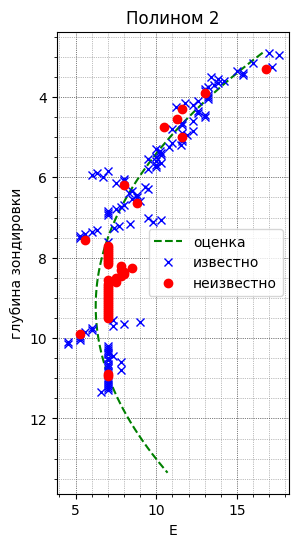

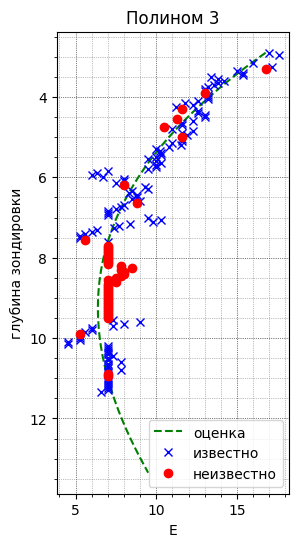

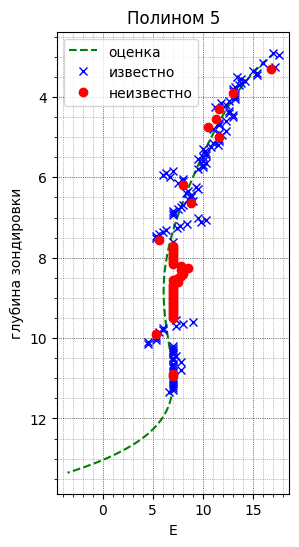

Test: -17.2074 6.99 8.38


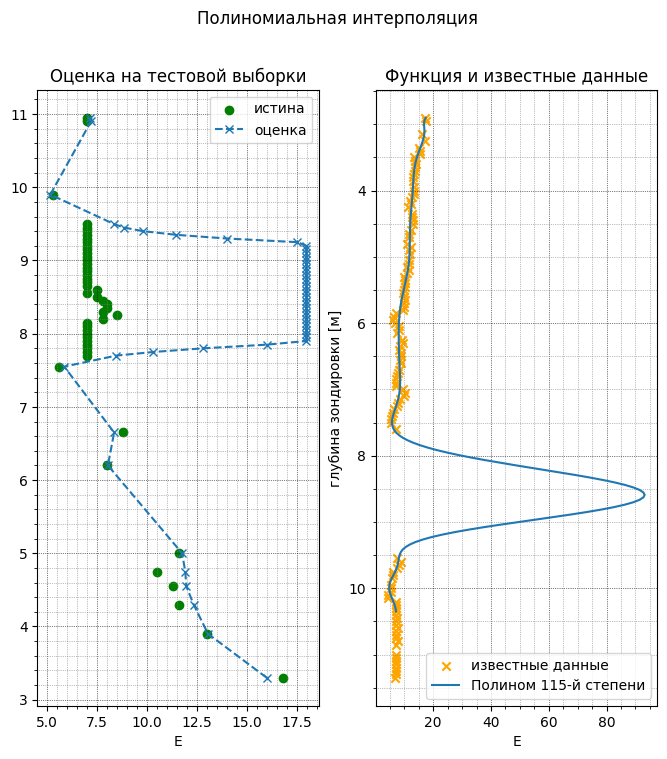

In [38]:
"""
Наилучший полином
"""
xi = x_train[:, 1]
yi = target_train

x_new = np.linspace(min(xi), 
                    max(xi)-1, 
                    200
                    )

r2_top = 0
best_n = 0
best_poly = None

"""
Кросс-валидация
"""
k = 10
blocks_X = np.array_split(xi, k)
blocks_y = np.array_split(yi, k)

for n in range(1, target_train.shape[0]):
    coeffs = np.polyfit(xi, yi, n)
    poly = np.poly1d(coeffs)
    scores = cross_valid_for_poly(poly, blocks_X, blocks_y, k)
    r2_now = np.mean(scores)
    
    
    if r2_now > r2_top:
        r2_top = r2_now
        best_n = n
        best_poly = poly

    if n in [2, 3, 5]:
        predict_test = poly(x_test[:, 1])
        r2_test = r2_score(target_test, predict_test)
        mae_test = round(mean_absolute_error(target_test, predict_test), 2)
        mape_test = mean_absolute_percentage_error(target_test, predict_test)
        rmse_test = round(mean_squared_error(target_test, predict_test)**0.5, 2)
        r2_dict[f"Poly_{n}"] = [r2_test, mae_test, rmse_test, mape_test]

        plt.figure(figsize=(3, 6))
        plt.plot(poly(np.linspace(df_now["h"].min(), np.max(df_now["h"])+2, 200)), 
                 np.linspace(df_now["h"].min(), np.max(df_now["h"])+2, 200), 
                 '--g', label="оценка"
                )
        plt.plot(target_train, x_train[:, 1], 'bx', label="известно")
        plt.plot(target_test, x_test[:, 1], 'ro', label="неизвестно")
        plt.xlabel('E')
        plt.ylabel('глубина зондировки')
        plt.gca().invert_yaxis()
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()
        plt.legend()
        plt.title(f"Полином {n}")
        plt.show()

"""
Качество на тестовой
"""
predict_test = best_poly(x_test[:, 1])
predict_test = np.where(predict_test> np.max(xi)+np.var(xi), np.max(xi)+np.var(xi), predict_test)
predict_test = np.where(predict_test< np.min(xi)-np.var(xi), 0, predict_test)
r2_test = r2_score(target_test, predict_test)
mae_test = round(mean_absolute_error(target_test, predict_test), 2)
mape_test = mean_absolute_percentage_error(target_test, predict_test)
rmse_test = round(mean_squared_error(target_test, predict_test)**0.5, 2)
print("Test:", round(r2_test, 4), mae_test, rmse_test)
r2_dict[f"BestPoly_{best_n}"] = [r2_test, mae_test, rmse_test, mape_test]

y_new = best_poly(xi)
#подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

#график на первом поле
ax1.scatter(target_test, x_test[:, 1], color='green', label='истина')
ax1.plot(predict_test, x_test[:, 1],  "--x", label='оценка')
ax1.set_title('Оценка на тестовой выборки')
ax1.set_xlabel('E')
ax1.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax1.minorticks_on()
ax1.legend()

#график на втором поле
ax2.scatter(target_train, x_train[:, 1], marker="x", color='orange', label='известные данные')
ax2.plot(best_poly(x_new), x_new, label=f'Полином {best_n}-й степени')
ax2.set_title('Функция и известные данные')
ax2.set_xlabel('E')
ax2.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax2.minorticks_on()
ax2.legend()

# Установите общий заголовок
fig.suptitle('Полиномиальная интерполяция')
plt.ylabel('глубина зондировки [м]')
plt.gca().invert_yaxis()
plt.show()

### Кригинг

0.9487582523302305 0.36272066515992796 0.44478547900080717


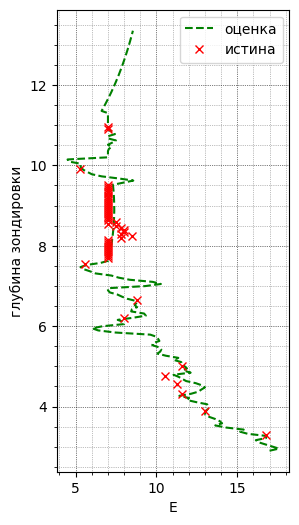

In [39]:
"""
Универсальный кригинг
"""
model = 'exponential'

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

OK = UniversalKriging(x, 
                      y, 
                      E, 
                      variogram_model=model
                        )

predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])

r2_now = r2_score(target_test, predict_test)
mae_now = mean_absolute_error(target_test, predict_test)
mape_now = mean_absolute_percentage_error(target_test, predict_test)
rmse_now = mean_squared_error(target_test, predict_test)**0.5
print(r2_now, mae_now, rmse_now)
r2_dict["UK"] = [r2_now, mae_now, rmse_now, mape_now]



x_new = np.array([0]*200)
y_new = np.linspace(np.min(y), np.max(y)+2, 200)
z_new, variance = OK.execute('points', x_new, y_new)

plt.figure(figsize=(3, 6))
#plt.plot(predict_test, x_test[:, 1], '*', label="оценка")
plt.plot(z_new, y_new, 'g--', label="оценка")
plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
plt.xlabel('E')
plt.ylabel('глубина зондировки')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.legend()
plt.show()

## Модели ML

In [40]:
svr_model1 = SVR(C=0.1, gamma="auto", kernel='rbf')
svr_model2 = SVR(C=0.1, gamma="auto", kernel="sigmoid")
#svr_model3 = SVR(C= 10, coef0= np.min(target_test), epsilon= 0.1, gamma= 'scale', kernel= 'sigmoid')
lr_model = LinearRegression(copy_X=True, fit_intercept=False)
br_model = BayesianRidge()
et_model = ExtraTreeRegressor()
tr_model = TweedieRegressor()

regression model: SVR SVR1
0.5835268897876791 0.9859185035679257 1.2680375566761333


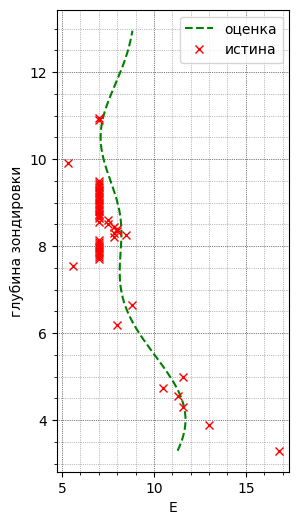

regression model: SVR SVR2
-0.1853498356706078 1.7867361019569585 2.1392517969152283


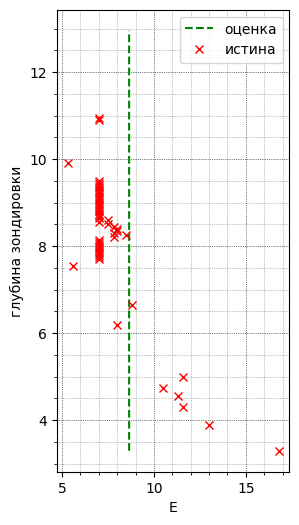

regression model: LinearRegression LR
-2.610725223285771 2.9796947685881925 3.7336693398033938


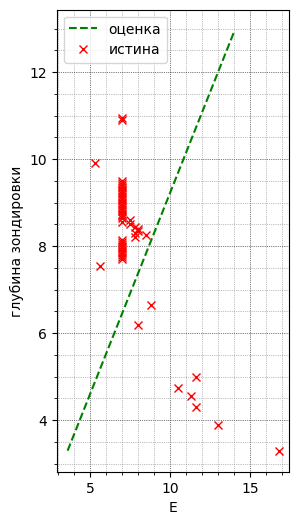

regression model: BayesianRidge BR
0.679185671247609 0.7842226399560075 1.1129240106825176


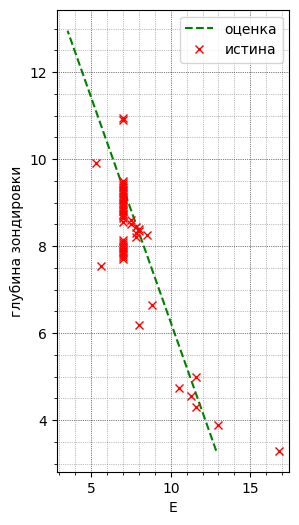

regression model: ExtraTreeRegressor ET
0.9281633436823743 0.3938775510204081 0.5266373883190504


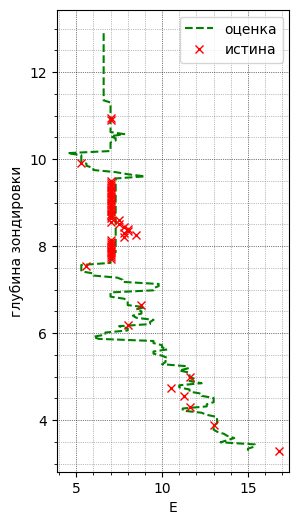

regression model: TweedieRegressor TR
0.621774128945396 0.9137966768732578 1.2084098298776098


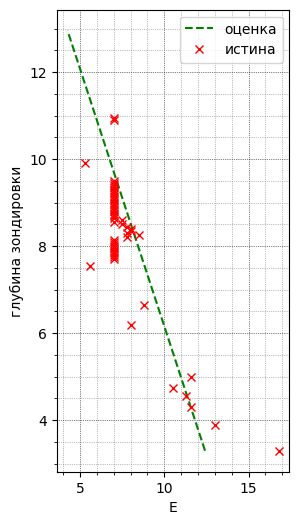

In [41]:
models = [svr_model1, svr_model2, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1", "SVR2", "LR", "BR", "ET", "TR"]
dict_models = {}

for i in range(len(models)):
    m = models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])

    m.fit(p_train, target_train)


    predict_test = m.predict(p_test)
    
    r2_now = r2_score(target_test, predict_test)
    mae_now = mean_absolute_error(target_test, predict_test)
    mape_now = mean_absolute_percentage_error(target_test, predict_test)
    rmse_now = mean_squared_error(target_test, predict_test)**0.5
    print(r2_now, mae_now, rmse_now)
    r2_dict[name] = [r2_now, mae_now, rmse_now, mape_now]

    x_new = np.array([0]*200)
    y_new = np.linspace(np.min(x_test[:, 1]), np.max(x_test[:, 1])+2, 200)
    data = np.array([x_new, y_new]).T
    z_new = m.predict(data)
    
    plt.figure(figsize=(3, 6))
    #plt.plot(predict_test, x_test[:, 1], '*', label="оценка")
    plt.plot(z_new, y_new, 'g--', label="оценка")
    plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
    plt.xlabel('E')
    plt.ylabel('глубина зондировки')
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Регрессионный кригинг

regression model: SVR SVR1+Kr
Finished learning regression model
Finished kriging residuals
0.9512947402965748 0.3684501655808934 0.43363723368117196


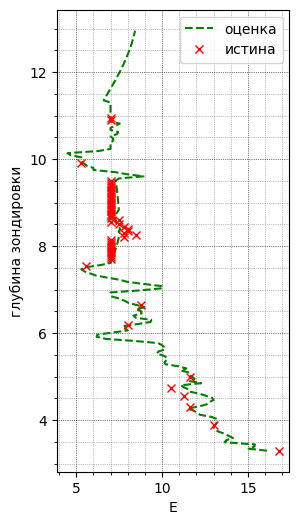

regression model: SVR SVR2+Kr
Finished learning regression model
Finished kriging residuals
0.9547269670095291 0.295493938467694 0.41807907228762864


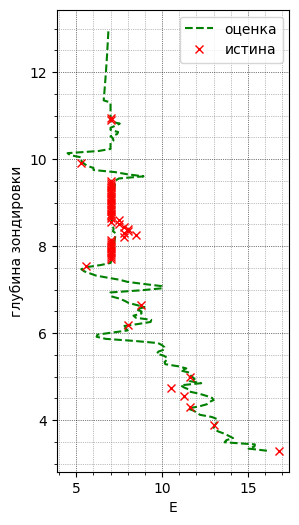

regression model: LinearRegression LR+Kr
Finished learning regression model
Finished kriging residuals
0.9369863914527604 0.3961679877664863 0.4932371831922192


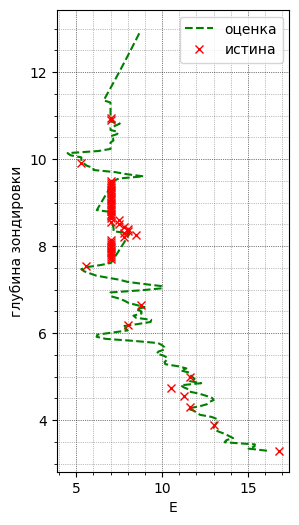

regression model: BayesianRidge BR+Kr
Finished learning regression model
Finished kriging residuals
0.9289001425843332 0.3831441594936509 0.5239296764073637


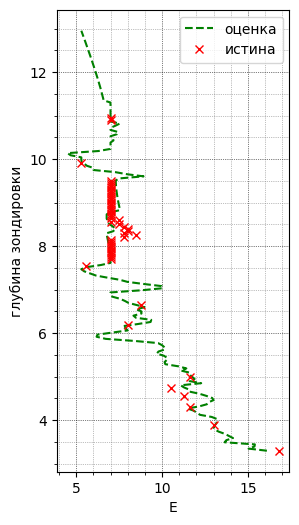

regression model: ExtraTreeRegressor ET+Kr
Finished learning regression model
Each lower bound must be strictly less than each upper bound.
regression model: TweedieRegressor TR+Kr
Finished learning regression model
Finished kriging residuals
0.9368749459807415 0.3500461497506431 0.49367315860256367


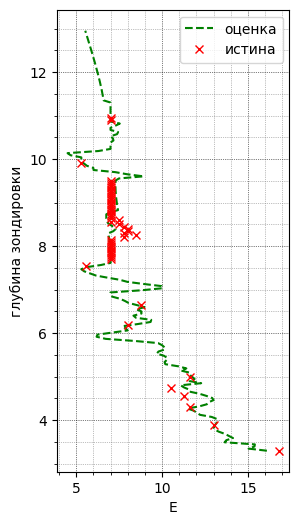

In [42]:
models = [svr_model1, svr_model2, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1+Kr", "SVR2+Kr", "LR+Kr", "BR+Kr", "ET+Kr", "TR+Kr"]
dict_models = {}

for i in range(len(models)):
    m = models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])
    
    try:
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model='exponential')
        m_rk.fit(p_train, x_train, target_train)
        dict_models[name] = m_rk


        x_new = np.array([0]*200)
        y_new = np.linspace(np.min(x_test[:, 1]), np.max(x_test[:, 1])+2, 200)
        data = np.array([x_new, y_new]).T
        z_new = m_rk.predict(data, data)

        predict_test = m_rk.predict(p_test, x_test)

        r2_now = r2_score(target_test, predict_test)
        mae_now = mean_absolute_error(target_test, predict_test)
        mape_now = mean_absolute_percentage_error(target_test, predict_test)
        rmse_now = mean_squared_error(target_test, predict_test)**0.5
        print(r2_now, mae_now, rmse_now)
        r2_dict[name] = [r2_now, mae_now, rmse_now, mape_now]

        z_new = m_rk.predict(data, data)
        plt.figure(figsize=(3, 6))
        plt.plot(z_new, y_new, 'g--', label="оценка")
        plt.plot(target_test, x_test[:, 1], 'rx', label="истина")
        plt.xlabel('E')
        plt.ylabel('глубина зондировки')
        plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.minorticks_on()
        plt.legend()
        plt.show()

    except Exception as ex:
        print(ex)

In [43]:
predict_mean = [np.mean(target_train)]*target_test.shape[0]
r2_dict["mean"] = [r2_score(target_test, predict_mean),
                   mean_absolute_error(target_test, predict_mean),
                   mean_squared_error(target_test, predict_mean)**0.5,
                   mean_absolute_percentage_error(target_test, predict_mean)
                  ]
r2_dict

{'ИГИ': [-4.474069503267607,
  4.322448979591837,
  4.597204119275727,
  0.5619932491437006],
 'Poly': [-42.86326865772026,
  10.54157479026105,
  13.01335056850181,
  1.4591753894719004],
 'Poly_2': [0.8018561008791614, 0.77, 0.87, 0.10057892432315861],
 'Poly_3': [0.8372533524506008, 0.68, 0.79, 0.08805448090152009],
 'Poly_5': [0.7429380280091726, 0.9, 1.0, 0.11868356380412529],
 'BestPoly_115': [-17.207423532266162, 6.99, 8.38, 0.9690343932936253],
 'UK': [0.9487582523302305,
  0.36272066515992796,
  0.44478547900080717,
  0.04630405892677722],
 'SVR1': [0.5835268897876791,
  0.9859185035679257,
  1.2680375566761333,
  0.13019440153051914],
 'SVR2': [-0.1853498356706078,
  1.7867361019569585,
  2.1392517969152283,
  0.2272440140917118],
 'LR': [-2.610725223285771,
  2.9796947685881925,
  3.7336693398033938,
  0.36666140763801996],
 'BR': [0.679185671247609,
  0.7842226399560075,
  1.1129240106825176,
  0.10385117512988007],
 'ET': [0.9281633436823743,
  0.3938775510204081,
  0.5266

In [44]:
df_test_result = pd.DataFrame(r2_dict).T
df_test_result.columns = ["R2", "MAE", "RMSE", "MAPE"]
df_test_result.sort_values(by=["R2", "MAPE"], ascending=[False, True]).applymap(lambda x: round(x, 3))

,R2,MAE,RMSE,MAPE
SVR2+Kr,0.955,0.295,0.418,0.036
SVR1+Kr,0.951,0.368,0.434,0.048
UK,0.949,0.363,0.445,0.046
LR+Kr,0.937,0.396,0.493,0.051
TR+Kr,0.937,0.350,0.494,0.044
BR+Kr,0.929,0.383,0.524,0.048
ET,0.928,0.394,0.527,0.048
Poly_3,0.837,0.680,0.790,0.088
Poly_2,0.802,0.770,0.870,0.101
Poly_5,0.743,0.900,1.000,0.119
